In [193]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import random

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.datasets as dset

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.utils.data as data_utils

import torch.nn as nn
import torch.nn.functional as F
import torch

In [123]:
n_epochs = 200
batch_size = 64
lr = 1e-4
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 40
img_size = 64
channels = 3
sample_interval=400
lam1 = 1e-1
lam2 = 1e-2
lam3 = 5
sample_pixels = sorted(random.sample(list(range(img_size*img_size*3)), 6500))

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

In [124]:
dataroot = "resized_data_bayc_no_background"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [125]:
samples = 5000
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).numpy()
    image_samples[i] = flat
image_samples_apes = image_samples.T[sample_pixels]
image_samples_apes = torch.tensor(image_samples_apes)

In [126]:
#mean_apes = np.mean(image_samples_apes, axis = 1)
#cov_apes = np.cov(image_samples_apes) + 0.0001*np.identity(len(sample_pixels)) 
#dist_apes = mvn(mean_apes, cov_apes)

In [127]:
dataroot = "resized_data_unicorns"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [128]:
samples = 1100
image_samples = np.zeros((samples, img_size*img_size*3))
for i in range(0, samples):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, _ = dataset[sample_idx]
    flat = torch.flatten(img).numpy()
    image_samples[i] = flat
image_samples_unicorns = image_samples.T[sample_pixels]
image_samples_unicorns = torch.tensor(image_samples_unicorns)

In [129]:
#mean_unicorns = np.mean(image_samples_unicorns, axis = 1)
#cov_unicorns = np.cov(image_samples_unicorns) + 0.0001*np.identity(len(sample_pixels)) 
#dist_unicorns = mvn(mean_unicorns, cov_unicorns)

In [467]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    
    def regularization(self, gen_imgs):
        
        result1 = 0
        result2 = 0
        sample_images = random.sample(list(range(len(gen_imgs))), 5)
        for i in sample_images:
            img = gen_imgs[i]
            flat = torch.flatten(img)[sample_pixels]
            a = torch.log(torch.min(torch.linalg.norm(torch.transpose(torch.transpose(image_samples_apes, 0, 1) - flat.expand(5000, len(sample_pixels)), 0, 1),dim=0)))
            #b = torch.log(torch.min(torch.linalg.norm(torch.transpose(torch.transpose(image_samples_unicorns, 0, 1) - flat.expand(1100, len(sample_pixels)), 0, 1),dim=0)))
            result1 += -a
            #result2 += -b
        return lam1*result1/len(sample_images) + lam2*result2/len(sample_images)
        
    def regularization_fast(self, gen_imgs, autoencoder):
        result = 0
        for img in gen_imgs:
            enc = torch.flatten(autoencoder.encode(img.view(1, *img.shape)))
            a = torch.log(torch.min(torch.linalg.norm(torch.transpose(torch.transpose(image_sample_apes_encoded, 0, 1) - enc.expand(1868, 32), 0, 1),dim=0)))
            result += -a
        return lam1*result/len(gen_imgs)
            
    def regularization2(self, classifier, gen_imgs):
        predictions = classifier(gen_imgs)
        p = torch.sum(predictions, dim=0)[1]/torch.sum(predictions)
        return lam3*(p*torch.log(2*p) + (1 - p)*torch.log(2*(1 - p)))
        
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [468]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [469]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 2),
            nn.Softmax(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        predictions = self.model(img_flat)

        return predictions

In [470]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
        )
        
        self.decoder = torch.nn.Sequential(
            nn.Linear(32, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, int(np.prod(img_shape))),
            nn.Tanh(),
        )
        
    def encode(self, x):
        x_flat = x.view(x.size(0), -1)
        return self.encoder(x_flat)
        
    def decode(self, encoded):
        decode = self.decoder(encoded)
        decode = decode.view(decode.size(0), *img_shape)
        return decode
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [363]:
classifier_loss = torch.nn.BCELoss()
classifier = Classifier()
if cuda:
    classifier.cuda()
    classifier_loss.cuda()
optimizer_C = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(b1, b2))

In [364]:
ae_loss = torch.nn.MSELoss()
ae = Autoencoder()
if cuda:
    ae.cuda()
    ae_loss.cuda()
optimizer_ae = torch.optim.Adam(ae.parameters(), lr=lr, betas=(b1, b2))

In [471]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [472]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [473]:
dataroot = "resized_data_mixed"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [368]:
indices = torch.arange(0,1868)
dataset1 = data_utils.Subset(dataset, indices)
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size,
                                         shuffle=True)

In [369]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader1):
        reconstructed = ae(imgs)
        optimizer_ae.zero_grad()
        loss = ae_loss(reconstructed, imgs)
        loss.backward()
        optimizer_ae.step()
        batches_done = epoch * len(dataloader1) + i

        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [AE loss: %f]"
                % (epoch, n_epochs, i, len(dataloader1), loss.item())
            )  

[Epoch 0/200] [Batch 0/30] [AE loss: 0.723617]
[Epoch 13/200] [Batch 10/30] [AE loss: 0.106132]
[Epoch 26/200] [Batch 20/30] [AE loss: 0.068161]
[Epoch 40/200] [Batch 0/30] [AE loss: 0.063492]
[Epoch 53/200] [Batch 10/30] [AE loss: 0.055330]
[Epoch 66/200] [Batch 20/30] [AE loss: 0.055649]
[Epoch 80/200] [Batch 0/30] [AE loss: 0.053509]
[Epoch 93/200] [Batch 10/30] [AE loss: 0.050813]
[Epoch 106/200] [Batch 20/30] [AE loss: 0.049302]
[Epoch 120/200] [Batch 0/30] [AE loss: 0.042130]
[Epoch 133/200] [Batch 10/30] [AE loss: 0.046514]
[Epoch 146/200] [Batch 20/30] [AE loss: 0.039975]
[Epoch 160/200] [Batch 0/30] [AE loss: 0.038913]
[Epoch 173/200] [Batch 10/30] [AE loss: 0.037278]
[Epoch 186/200] [Batch 20/30] [AE loss: 0.035064]


In [455]:
image_sample_apes_encoded = []
for i in range(len(dataset1)):
    img = dataset[i][0].view(1, *img_shape)
    enc = ae.encode(img).detach().view(-1, 32)[0]
    image_sample_apes_encoded.append(np.array(enc))
image_sample_apes_encoded = np.array(image_sample_apes_encoded).T    
image_sample_apes_encoded = torch.tensor(image_sample_apes_encoded)

In [456]:
image_sample_apes_encoded.shape

torch.Size([32, 1868])

In [474]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [400]:
for epoch in range(n_epochs//4):
    for i, (imgs, labels) in enumerate(dataloader):
        labels = torch.cat((labels.view(len(labels), 1), (1-labels).view(len(labels), 1)), 1).float()
        inp = Variable(imgs.type(Tensor))
        prediction = classifier(imgs)
        lab = Variable(labels.type(Tensor))
        optimizer_C.zero_grad()
        loss = classifier_loss(prediction, labels)
        loss.backward()
        optimizer_C.step()
        batches_done = epoch * len(dataloader) + i

        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [C loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), loss.item())
            )  

[Epoch 0/200] [Batch 0/67] [C loss: 0.672675]
[Epoch 5/200] [Batch 65/67] [C loss: 0.000021]
[Epoch 11/200] [Batch 63/67] [C loss: 0.000011]
[Epoch 17/200] [Batch 61/67] [C loss: 0.000001]
[Epoch 23/200] [Batch 59/67] [C loss: 0.000001]
[Epoch 29/200] [Batch 57/67] [C loss: 0.000001]
[Epoch 35/200] [Batch 55/67] [C loss: 0.000001]
[Epoch 41/200] [Batch 53/67] [C loss: 0.000000]
[Epoch 47/200] [Batch 51/67] [C loss: 0.000000]


In [475]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        regularize = generator.regularization_fast(gen_imgs, ae)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + regularize

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        batches_done = epoch * len(dataloader) + i

        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            save_image(gen_imgs.data[:25], "test/%d.png" % batches_done, nrow=5, normalize=True)    

[Epoch 0/200] [Batch 0/67] [D loss: 0.675963] [G loss: 0.286307]
[Epoch 5/200] [Batch 65/67] [D loss: 0.201108] [G loss: 1.133647]
[Epoch 11/200] [Batch 63/67] [D loss: 1.096573] [G loss: -0.074273]
[Epoch 17/200] [Batch 61/67] [D loss: 0.296016] [G loss: 0.660062]
[Epoch 23/200] [Batch 59/67] [D loss: 0.252975] [G loss: 1.185986]
[Epoch 29/200] [Batch 57/67] [D loss: 0.234399] [G loss: 1.028073]
[Epoch 35/200] [Batch 55/67] [D loss: 0.168292] [G loss: 2.012831]
[Epoch 41/200] [Batch 53/67] [D loss: 0.491887] [G loss: 2.704627]
[Epoch 47/200] [Batch 51/67] [D loss: 0.223282] [G loss: 1.491283]
[Epoch 53/200] [Batch 49/67] [D loss: 0.176546] [G loss: 1.563449]
[Epoch 59/200] [Batch 47/67] [D loss: 0.264487] [G loss: 1.129790]
[Epoch 65/200] [Batch 45/67] [D loss: 0.219745] [G loss: 1.551627]
[Epoch 71/200] [Batch 43/67] [D loss: 0.212652] [G loss: 1.870407]
[Epoch 77/200] [Batch 41/67] [D loss: 0.264425] [G loss: 1.390724]
[Epoch 83/200] [Batch 39/67] [D loss: 0.260996] [G loss: 1.85085

In [55]:
z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

In [56]:
gen_imgs = generator(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


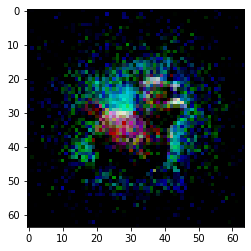

In [60]:
plt.imshow(  gen_imgs.data[4].permute(1, 2, 0)  )

In [421]:
gen_imgs[0].shape

torch.Size([3, 64, 64])

In [58]:
torch.sum(classifier(gen_imgs), dim = 0)

tensor([7.0000, 6.0000], grad_fn=<SumBackward1>)

In [38]:
classifier(gen_imgs)

tensor([[6.9441e-01, 3.0559e-01],
        [1.0000e+00, 1.3509e-07],
        [8.9473e-09, 1.0000e+00],
        [1.0000e+00, 1.1838e-06],
        [1.0000e+00, 1.2146e-06],
        [1.0000e+00, 2.2536e-08],
        [5.3620e-08, 1.0000e+00],
        [1.0000e+00, 3.8124e-08],
        [4.2431e-05, 9.9996e-01],
        [3.5550e-08, 1.0000e+00],
        [1.0000e+00, 2.0724e-06],
        [6.0243e-08, 1.0000e+00],
        [1.1111e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)